In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
url='https://raw.githubusercontent.com/npradaschnor/Pima-Indians-Diabetes-Dataset/master/diabetes.csv'
df = pd.read_csv(url)
print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [3]:
X = df.drop('Outcome', axis =1).values
y = df['Outcome'].values

In [4]:
X = torch.FloatTensor(X)
y = torch.FloatTensor(y).unsqueeze(1)

In [5]:
X_train,X_test,y_train,y_test = train_test_split(X,y, random_state=42, test_size=0.2, shuffle=True)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,random_state=42, test_size=0.2, shuffle=True )

In [6]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
val_dataset = TensorDataset(X_val, y_val)


In [7]:
train_loader = DataLoader(train_dataset, batch_size = 20, shuffle = True)
# test_loader = DataLoader(test_dataset, batch_size = 1, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = 1, shuffle = True)

In [8]:
class PimaClassifier (nn.Module):
  def __init__(self):
    super().__init__()

    self.input = nn.Linear(8,12)
    self.h1 = nn.Linear(12,8)
    self.output = nn.Linear(8,1)

  def  forward (self,x):

    x = F.relu(self.input(x))
    x = F.relu(self.h1(x))
    x= torch.sigmoid(self.output(x))

    return x

In [9]:
torch.manual_seed(1)
model = PimaClassifier()
model

PimaClassifier(
  (input): Linear(in_features=8, out_features=12, bias=True)
  (h1): Linear(in_features=12, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=1, bias=True)
)

In [10]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

In [11]:
epochs = 250
train_loss = []
val_loss = []

for epoch in range(epochs):
    epoch_loss = 0
    model.train()
    for Xtrain,ytrain in train_loader:
        y_pred = model(Xtrain)
        loss = criterion(y_pred,ytrain)
        optimizer.zero_grad()
        epoch_loss += loss.item() * Xtrain.size(0)
        loss.backward()
        optimizer.step()
    epoch_loss /= len(train_loader.dataset) 
    train_loss.append(epoch_loss)

    model.eval()
    with torch.no_grad():
        val_epoch_loss = 0
        for Xval,yval in val_loader:
            val_pred = model(Xval)
            loss = criterion(val_pred,yval)
            val_epoch_loss += loss.item() * Xval.size(0)
        val_epoch_loss /= len(val_loader.dataset) 
        val_loss.append(val_epoch_loss)
    if epoch % 10 == 0:
        print(f'training loss :{epoch_loss}, validation loss :{val_epoch_loss}')

training loss :1.004664225879366, validation loss :0.8746900528033332
training loss :0.753137006900461, validation loss :0.7348809580174767
training loss :0.6845978267809524, validation loss :0.6907601965273299
training loss :0.6588301657416428, validation loss :0.6680763929597731
training loss :0.6421537890939266, validation loss :0.6562738191730123
training loss :0.6314749289190211, validation loss :0.6500079822007233
training loss :0.6242709312808004, validation loss :0.6430130051373224
training loss :0.615193579930152, validation loss :0.6385486887813341
training loss :0.6093003785051785, validation loss :0.6340743833319927
training loss :0.6030358998692934, validation loss :0.6302087665421934
training loss :0.5964634210903145, validation loss :0.6273897345351979
training loss :0.5917427044536334, validation loss :0.6251993648919875
training loss :0.5881406494289212, validation loss :0.6238185970975858
training loss :0.5847295068674806, validation loss :0.6221002771753849
training 

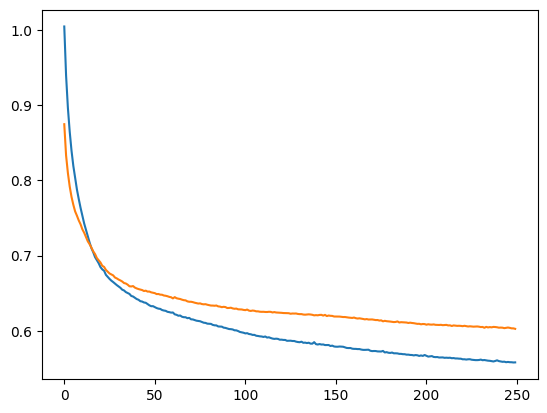

In [12]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

In [13]:
with torch.no_grad():
    model.eval()
    y_test_pred = model(X_test)
    loss_val = criterion(y_test_pred, y_test).item()

    correct = (y_test_pred.round() == y_test).float().sum()
    total = float(y_test.size(0))
    print("Testing Accuracy :",((correct / total) * 100 ).item())
    print(f"got {correct} correct from {len(X_test)}")

Testing Accuracy : 72.07792663574219
got 111.0 correct from 154


In [14]:
def add_noise(X_train,y_train,num_of_times,mean=0,std=0.2):

  new_X_train=[]
  new_y_train=[]

  for _ in range(num_of_times):
    # data=X_train.clone
    noisy_data=X_train[:,1:].clone()
    noise=torch.randn_like(noisy_data) * std + mean
    noisy_data += noise
    noisy_data = torch.cat((X_train[:,0].unsqueeze(1),noisy_data), dim=1)
    new_X_train.append(noisy_data)
    new_y_train.append(y_train.clone())

  return torch.cat(new_X_train, dim=0) , torch.cat(new_y_train, dim=0)


X_train_noisy,y_train_noisy = add_noise(X_train,y_train,num_of_times=2)

In [15]:
noise_dataset = TensorDataset(X_train_noisy, y_train_noisy)
noise_loader = DataLoader(noise_dataset, batch_size = 20, shuffle = True)

In [16]:
torch.manual_seed(45)
model1 = PimaClassifier()
model1

PimaClassifier(
  (input): Linear(in_features=8, out_features=12, bias=True)
  (h1): Linear(in_features=12, out_features=8, bias=True)
  (output): Linear(in_features=8, out_features=1, bias=True)
)

In [17]:
loss_function = nn.BCELoss()
optimizer1 = torch.optim.Adam(model1.parameters(), lr = 0.0001)

In [18]:
epochs = 250
train_loss = []
val_loss = []

for epoch in range(epochs):
    epoch_loss = 0
    model1.train()
    for Xnoise,ynoise in noise_loader:
        noise_pred = model1(Xnoise)
        noise_loss = loss_function(noise_pred,ynoise)
        optimizer1.zero_grad()
        epoch_loss += noise_loss.item() * Xnoise.size(0)
        noise_loss.backward()
        optimizer1.step()
    epoch_loss /= len(noise_loader.dataset) 
    train_loss.append(epoch_loss)

    model1.eval()
    with torch.no_grad():
        val_epoch_loss = 0
        for Xval,yval in val_loader:
            val_pred = model1(Xval)
            loss = loss_function(val_pred,yval)
            val_epoch_loss += loss.item() * Xval.size(0)
        val_epoch_loss /= len(val_loader.dataset) 
        val_loss.append(val_epoch_loss)
    if epoch % 10 == 0:
        print(f'training loss :{epoch_loss}, validation loss :{val_epoch_loss}')

training loss :1.7250659609035173, validation loss :1.4297004369640254
training loss :0.7762245569840953, validation loss :0.7392872413052474
training loss :0.70324735024796, validation loss :0.6751777255544211
training loss :0.6720824339360666, validation loss :0.656547106620742
training loss :0.6510202121103368, validation loss :0.6469391775658218
training loss :0.6347359162726859, validation loss :0.6393033001359886
training loss :0.6221696705293752, validation loss :0.6348560788948846
training loss :0.6128787983459271, validation loss :0.6320440873988276
training loss :0.6044935758876218, validation loss :0.62984148755185
training loss :0.5973893491410918, validation loss :0.6279922352301154
training loss :0.5907902727908855, validation loss :0.6271598536551484
training loss :0.5841400090400167, validation loss :0.6266325815785222
training loss :0.5782258195571162, validation loss :0.6251301060816864
training loss :0.5729564692969235, validation loss :0.624435251790697
training los

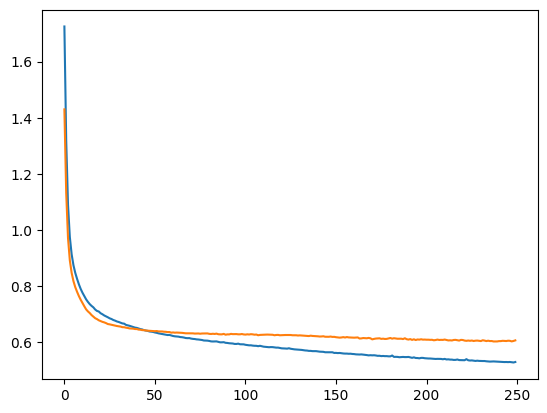

In [19]:
plt.plot(train_loss)
plt.plot(val_loss)
plt.show()

In [20]:
with torch.no_grad():
    model1.eval()
    y_test_pred = model1(X_test)
    loss_test = loss_function(y_test_pred, y_test).item()

    correct = (y_test_pred.round() == y_test).float().sum()
    total = float(y_test.size(0))
    print("Testing Accuracy :",((correct / total) * 100 ).item())
    print(f"got {correct} correct from {len(X_test)}")

Testing Accuracy : 74.0259780883789
got 114.0 correct from 154
